In [1]:
import pandas as pd
import numpy as np
import os
import sys
import configparser
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

sys.path.append(os.path.abspath('../Module'))
import preprocessing
import evaluation
import visualize

config = configparser.ConfigParser()
config.read('../config.ini')

vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
image_dir = config['PATHS']['vg-images']

colors = preprocessing.basic_colors()
num_classes = 11

# Daten importieren

In [49]:
# Gezippte Numpy-Archive importieren
perceptron_arrays = np.load(vg_json_export+'baseline_arrays_gbr.npz')

train_x = perceptron_arrays['train_x']
train_y = perceptron_arrays['train_y']
test_x = perceptron_arrays['test_x'][:20000]
test_y = perceptron_arrays['test_y'][:20000]

# Objektinformationen als DataFrames 

all_obj = pd.read_csv(vg_json_export+"extracted_data/all_objects.csv", index_col=0)
test_obj = pd.read_csv(vg_json_export+"extracted_data/test_df.csv", index_col=0)
train_obj = pd.read_csv(vg_json_export+"extracted_data/train_df.csv", index_col=0)

# Frequente Objekte + CDOs + CNOs:
frequent_objects, color_diagnostic_objects, color_biased_objects, color_neutral_objects = preprocessing.freq_cdo_cno(all_obj, num_cdos=100, num_cnos=100, min_num=100)
# test_obj auf frequente Objekte reduzieren
freq_obj = test_obj.loc[test_obj.object_name.isin(frequent_objects)]
# DataFrames für CDOs, CBOs und CNOs
cd_obj = freq_obj .loc[freq_obj.object_name.isin(color_diagnostic_objects.keys())]
cb_obj = freq_obj.loc[freq_obj.object_name.isin(color_biased_objects)]
cn_obj = freq_obj.loc[freq_obj.object_name.isin(color_neutral_objects)]

# Objekte mit ambiger Farbbezeichnung aus Test-Set

colors_per_object_id = all_obj.groupby(['object_id','color']).size().reset_index(name='count')\
                        .groupby('object_id').size().reset_index(name='count').sort_values(by='count',ascending=False)
object_ids_multiple_colors = colors_per_object_id.loc[colors_per_object_id['count']>1].object_id.values

single_color_index = all_obj.loc[np.logical_not(all_obj['object_id'].isin(object_ids_multiple_colors))].index

test_x = pd.DataFrame(test_x).loc[pd.DataFrame(test_x)[0].isin(single_color_index)].to_numpy()
test_y = pd.DataFrame(test_y).loc[pd.DataFrame(test_y)[0].isin(single_color_index)].to_numpy()

freq_obj = freq_obj.loc[freq_obj.index.isin(single_color_index)]

train_x = pd.DataFrame(train_x).loc[pd.DataFrame(train_x)[0].isin(single_color_index)].to_numpy()
train_y = pd.DataFrame(train_y).loc[pd.DataFrame(train_y)[0].isin(single_color_index)].to_numpy()

print (train_x.shape)
print (test_x.shape)

(481187, 513)
(15860, 513)


# Undersampling mit bereinigten Daten

In [107]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

clss, cnt = np.unique(train_y[:,1:].argmax(axis=1), return_counts=True)
classes = dict(zip(clss,cnt))
oversampling_classes = {i:(classes[i] if classes[i] >= 15000 else 15000) for i in classes}

ros = RandomOverSampler(random_state=123, sampling_strategy = oversampling_classes)
rus = RandomUnderSampler(random_state=123)

pipeline = Pipeline([('ros', ros), ('rus', rus)])

X_res, y_res = pipeline.fit_resample(train_x[:,1:], train_y[:,1:].argmax(axis=1))
y_res = np.eye(11)[y_res]

# Modell compilen, Funktionen definieren

In [113]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
import numpy as np

batch_size = 128
epochs = 25

def train_model(model, tr_x, tr_y, te_x, te_y, verbose=1):
    tr_x = (tr_x[:,1:] if tr_x.shape[1] == 513 else tr_x)
    te_x = (te_x[:,1:] if te_x.shape[1] == 513 else te_x)
    tr_y = (tr_y[:,1:] if tr_y.shape[1] == 12 else tr_y)
    te_y = (te_y[:,1:] if te_y.shape[1] == 12 else te_y)

    print(tr_x.shape[0], 'train samples')
    print(te_x.shape[0], 'test samples')

    history = model.fit(tr_x, tr_y,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=verbose,
                        validation_data=(te_x, te_y))

    _predict_y = model.predict(te_x)
    #score = model.evaluate(te_x, te_y, verbose=0)
    #print('Test loss:', score[0])
    #print('Test accuracy:', score[1])
    
    # IDs zu Perceptron-Prediction-Array hinzufügen (bei Pixelwise-Arrays bereits beinhaltet)
    ids = test_y[:,0:1]
    predict_y = np.append(ids, _predict_y, axis=1)

    # DataFrames aus Predictions (np-Arrays) erstellen
    perceptron_predict_df =  pd.DataFrame(data=predict_y[0:,1:],index=predict_y[0:,0],columns=colors).sort_index()

    # Farbwort mit höchstem Wert (-> prognostiziertes Farbwort) (ergibt pd.Series)
    pred_label_perceptron = perceptron_predict_df.idxmax(axis=1)

    # Predictions mit freq_obj kombinieren
    predict_df = freq_obj.copy().reindex(ids.ravel().astype(int)).sort_index()
    predict_df['predicted_color'] = pred_label_perceptron

    # DFs für CDOs, CNOs und CBOs
    predict_cdo = predict_df.reindex(cd_obj.index.to_list()).sort_index()
    predict_cbo = predict_df.reindex(cb_obj.index.to_list()).sort_index()
    predict_cno = predict_df.reindex(cn_obj.index.to_list()).sort_index()
    
    return (predict_df, perceptron_predict_df)

def evaluation_metrics(dfs):
    predict_df, perceptron_predict_df = dfs
    evaluation.evaluation_metrics('predicted_color', predict_df, verbose=False)
    print ('mean reciprocal rank', evaluation.get_label_ranking_average_precision_score(predict_df.color, perceptron_predict_df))

    evaluation.plot_confusion_matrix(predict_df['color'], predict_df['predicted_color'], classes=colors, normalize=True, error_matrix=False, cmap=plt.cm.Greens)
    evaluation.plot_confusion_matrix(predict_df['color'], predict_df['predicted_color'], classes=colors, normalize=True, error_matrix=True, cmap=plt.cm.Reds)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_62 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 240)               123120    
_________________________________________________________________
dropout_63 (Dropout)         (None, 240)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 24)                5784      
_________________________________________________________________
dropout_64 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_88 (Dense)             (None, 11)                275       
Total para

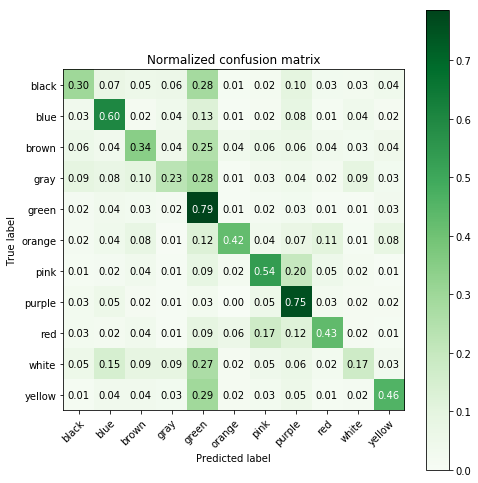

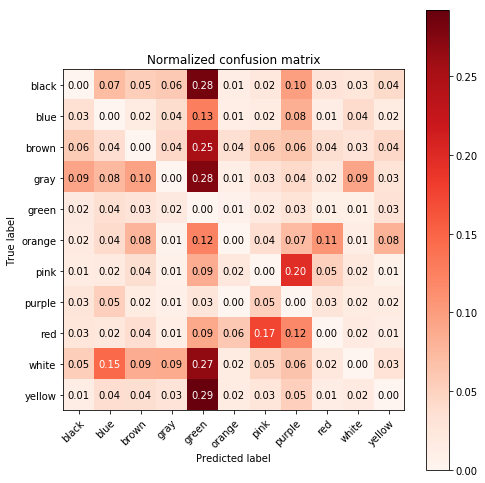

In [114]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(512,)))
model.add(Dropout(0.2))
model.add(Dense(240, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

evaluation_metrics(train_model(model, X_res, y_res, test_x, test_y, verbose=0))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_65 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 240)               123120    
_________________________________________________________________
dropout_66 (Dropout)         (None, 240)               0         
_________________________________________________________________
dense_91 (Dense)             (None, 24)                5784      
_________________________________________________________________
dropout_67 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_92 (Dense)             (None, 11)                275       
Total para

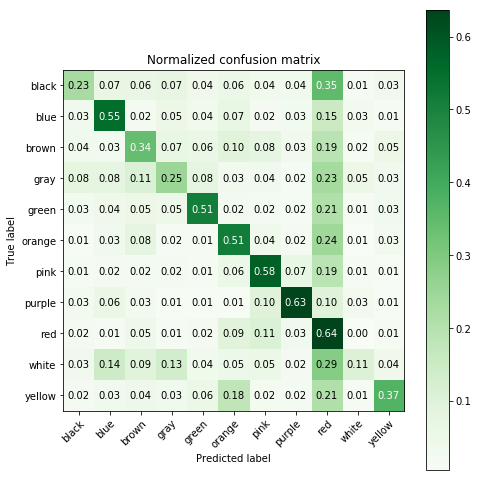

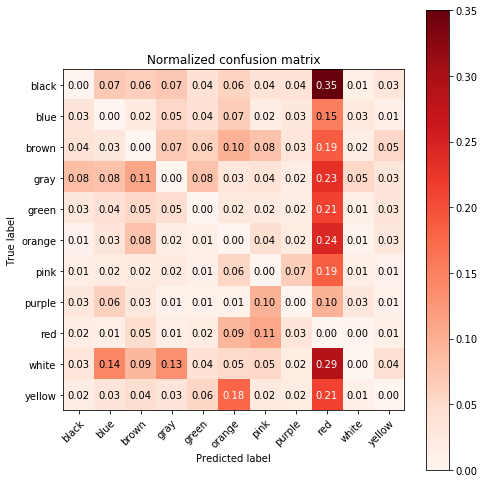

In [115]:
model = Sequential()
model.add(Dense(512, activation='elu', input_shape=(512,)))
model.add(Dropout(0.2))
model.add(Dense(240, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(24, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

evaluation_metrics(train_model(model, X_res, y_res, test_x, test_y, verbose=0))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_71 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_98 (Dense)             (None, 240)               123120    
_________________________________________________________________
dropout_72 (Dropout)         (None, 240)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 24)                5784      
_________________________________________________________________
dropout_73 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 11)                275       
Total para

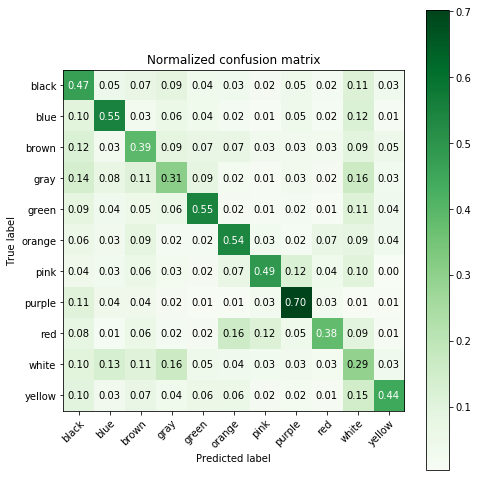

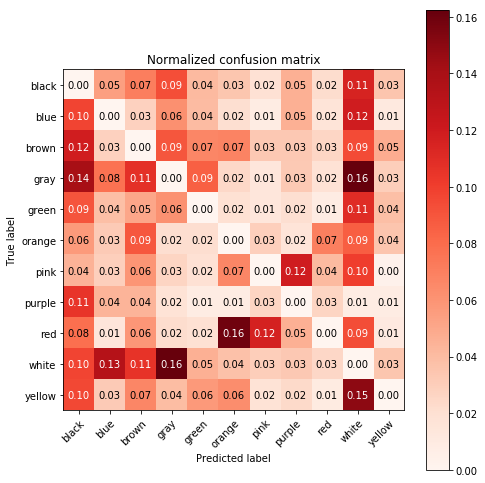

In [117]:
model = Sequential()
model.add(Dense(512, activation='selu', input_shape=(512,)))
model.add(Dropout(0.2))
model.add(Dense(240, activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(24, activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

evaluation_metrics(train_model(model, X_res, y_res, test_x, test_y, verbose=0))